In [2]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv('tw_source.csv', header=None, encoding='latin1')  

df.columns = ['Ref', 'id', 'Fecha', 'Fuente', 'Usuario', 'Tweet']  

print(df.head())

   Ref          id                         Fecha    Fuente          Usuario  \
0    0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1    0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2    0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3    0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4    0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                               Tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In [3]:
df.count()

Ref        1600000
id         1600000
Fecha      1600000
Fuente     1600000
Usuario    1600000
Tweet      1600000
dtype: int64

## Extraer Menciones


In [4]:

df['Menciones'] = df['Tweet'].apply(lambda x: re.findall(r'@\w+', x))

menciones_expandidas = df.explode('Menciones')

top_usuarios = menciones_expandidas['Menciones'].value_counts().head(3)
print(top_usuarios)


Menciones
@mileycyrus    4500
@tommcfly      3887
@ddlovato      3467
Name: count, dtype: int64


In [ ]:

top_users_list = top_usuarios.index.tolist()

# Realizar el corpus

corpus = {}

for user in top_users_list:
    user_tweets = menciones_expandidas[menciones_expandidas['Menciones'] == user]

    
    user_corpus = user_tweets[['id', 'Fecha', 'Tweet']]
    user_corpus['Length'] = user_corpus['Tweet'].apply(len)

   
    corpus[user] = user_corpus

    print(f"Información para {user}:")
    print(user_corpus.head(), "\n")

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [8]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalnum() and token.lower() not in stop_words]
    return tokens

In [9]:
user_context = {}

# Extraer las palabras que se encuentran en la mencion de los usuarios
for user in top_users_list:
    user_tweets = corpus[user]['Tweet'].tolist()
    context_words = []

    for tweet in user_tweets:
        tokens = preprocess_text(tweet)
        if user.strip('@') in tokens:
            user_index = tokens.index(user.strip('@'))
            context_words.extend(tokens[max(0, user_index-5):user_index])
            context_words.extend(tokens[user_index+1:min(len(tokens), user_index+4)])

    
    user_context[user] = Counter(context_words)


    print(f"Palabras más comunes para el usuario: {user}:")
    print(user_context[user].most_common(10), "\n")

Palabras más comunes para el usuario: @mileycyrus:
[('miley', 572), ('http', 490), ('love', 391), ('u', 207), ('good', 187), ('hey', 173), ('quot', 173), ('hope', 138), ('vote', 134), ('come', 132)] 

Palabras más comunes para el usuario: @tommcfly:
[('tom', 561), ('say', 190), ('http', 182), ('hey', 154), ('u', 147), ('please', 142), ('good', 138), ('love', 122), ('guy', 108), ('reply', 102)] 

Palabras más comunes para el usuario: @ddlovato:
[('demi', 430), ('love', 246), ('http', 182), ('u', 173), ('wish', 170), ('hey', 120), ('come', 114), ('hope', 109), ('im', 108), ('please', 104)] 



In [ ]:
pip install wordcloud


In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

WordCloud para @mileycyrus


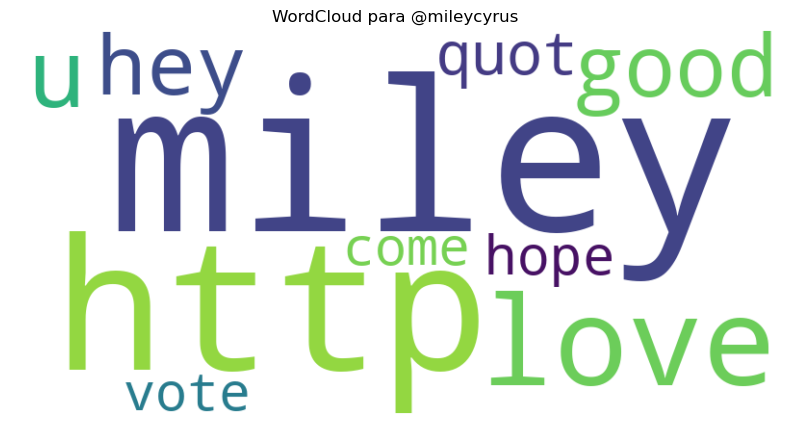

WordCloud para @tommcfly


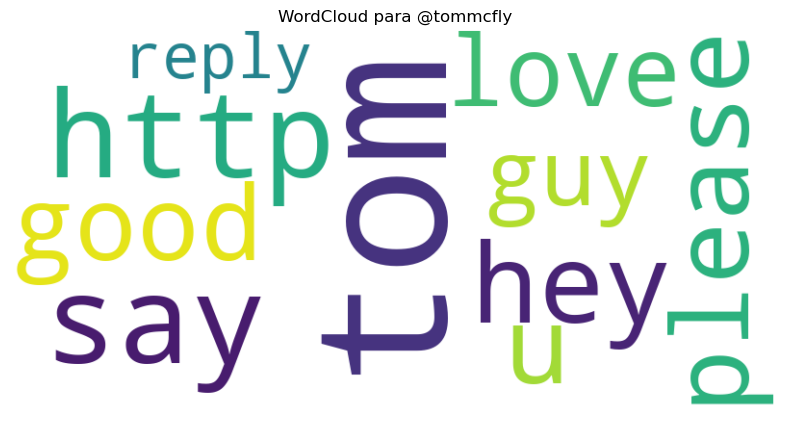

WordCloud para @ddlovato


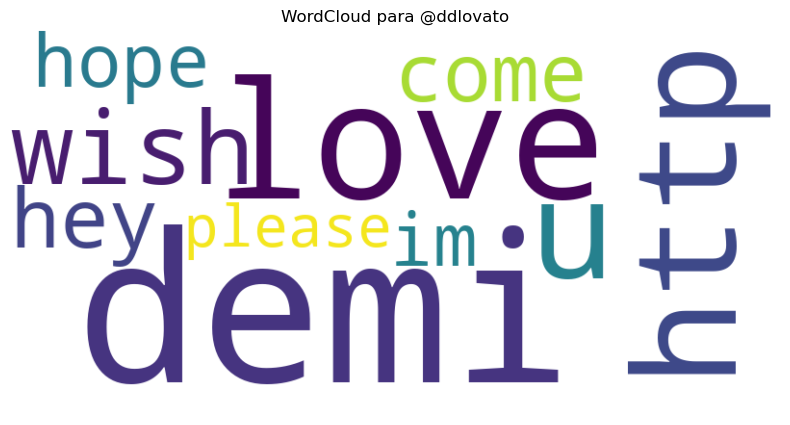

In [17]:

# Generar y mostrar un WordCloud
def generate_wordcloud(context_counter, title, colormap='magma'):
    
    top_10_palabras = dict(sorted(context_counter.items(), key=lambda item: item[1], reverse=True)[:10])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_10_palabras)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for user in top_users_list:
    print(f"WordCloud para {user}")
    generate_wordcloud(user_context[user], f"WordCloud para {user}")
